In [1]:
# reading in files from google drive to speed up run time
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#MovieLens Dataset EDA

This dataset (ml-latest-small) describes 5-star rating and free-text tagging activity from [MovieLens](http://movielens.org), a movie recommendation service. It contains 100836 ratings and 3683 tag applications across 9742 movies. These data were created by 610 users between March 29, 1996 and September 24, 2018. This dataset was generated on September 26, 2018.


##Loading dependencies

In [2]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=2811638 sha256=f907e8980e6d206228b8134303e21a3799e9fd9b4341920da625d4805dfce5bb
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [3]:
import surprise
from surprise.prediction_algorithms import *
from surprise import Reader, Dataset


from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.model_selection import GridSearchCV


import datetime as dt

import numpy as np
import pandas as pd

import sqlalchemy
from sqlalchemy import create_engine, text
import sqlite3


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity
from ast import literal_eval

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Create the engine to connect to the inbuilt
# sqllite database
engine = create_engine("sqlite+pysqlite:///:memory:")

## Reading in the tables

###Dataframes

In [6]:
movies_df = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/Phase4-Project-Data/movies.csv")

In [7]:
ratings_df = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/Phase4-Project-Data/ratings.csv")

###SQL

In [10]:
movies_df.to_sql('movies', con=engine, if_exists='replace')

9742

In [11]:
ratings_df.to_sql('ratings', con=engine, if_exists='replace')

100836

##Previewing the data

###Exploring `movies.csv`

In [13]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [14]:
#Note: might want to split genres into separate columns
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


###Exploring `ratings.csv`

In [ ]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [ ]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
ratings_df.tail()

,userId,movieId,rating,timestamp
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352
100835,610,170875,3.0,1493846415


In [ ]:
ratings_df['movieId'].value_counts()

356       329
318       317
296       307
593       279
2571      278
         ... 
86279       1
86922       1
5962        1
87660       1
163981      1
Name: movieId, Length: 9724, dtype: int64

In [ ]:
ratings_df['userId'].value_counts()

414    2698
599    2478
474    2108
448    1864
274    1346
       ... 
442      20
569      20
320      20
576      20
53       20
Name: userId, Length: 610, dtype: int64

###Exploring distribution of ratings (score, count)

In [ ]:
stats = ratings_df[['rating', 'timestamp']].describe()
stats

,rating,timestamp
count,100836.000000,1.008360e+05
mean,3.501557,1.205946e+09
std,1.042529,2.162610e+08
min,0.500000,8.281246e+08
25%,3.000000,1.019124e+09
50%,3.500000,1.186087e+09
75%,4.000000,1.435994e+09
max,5.000000,1.537799e+09


In [ ]:
print(dt.datetime.fromtimestamp(stats.loc['min', 'timestamp']))
print(dt.datetime.fromtimestamp(stats.loc['max', 'timestamp']))

1996-03-29 18:36:55
2018-09-24 14:27:30


In [36]:
# create a variable for easier reuse
user_ratings_count = ratings_df['userId'].value_counts()

# calculate mean
mean_ratings = user_ratings_count.mean()
print("Mean: ", mean_ratings)

# calculate median
median_ratings = user_ratings_count.median()
print("Median: ", median_ratings)

# calculate mode
mode_ratings = user_ratings_count.mode()[0]
print("Mode: ", mode_ratings)


Mean:  165.30491803278687
Median:  70.5
Mode:  21


##Visualizing movie popularity and user activity

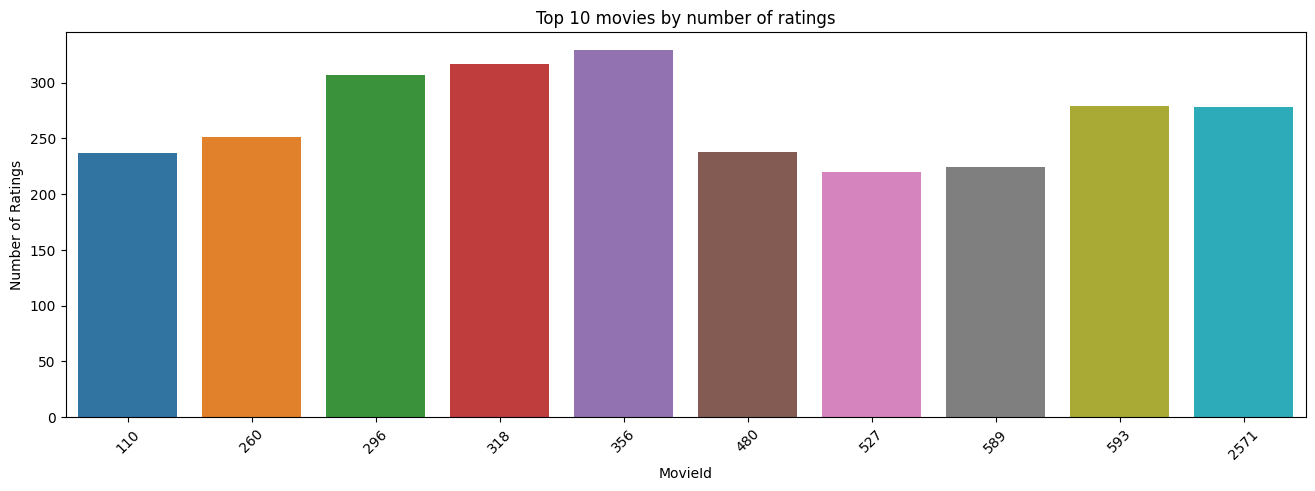

In [ ]:
# Top 10 movies with the most ratings

# creating variables
movies_rated_count = ratings_df['movieId'].value_counts()
top_movies = movies_rated_count[:10]

plt.figure(figsize=(16,5))
sns.barplot(x=top_movies.index, y=top_movies.values)
plt.xlabel("MovieId")
plt.ylabel("Number of Ratings")
plt.title("Top 10 movies by number of ratings")
plt.xticks(rotation=45)
plt.show();


##Join movies and ratings + create 3 versions of the dataset
1. `df_movies_and_raters`: each record is a user, genres are left in one column as in the original dataset
2. `df_movies_raters_genres`: each record is a user, genres are split into 9 different columns
3. `df_movies_raters_2_genres`: each record is a user, genres are split into 2 columns, `main_genre` contains the first in the list, `subgenre_1` contains the second.

###Creating `df_movies_and_raters`

In [15]:
query = \
"""
SELECT  r.userID, r.rating, r.movieID, m.title, m.genres
FROM ratings as r
LEFT JOIN movies AS m ON m.movieId = r.movieId;

"""
df_movies_and_raters = pd.read_sql_query(sql=text(query), con=engine.connect())

In [ ]:
df_movies_and_raters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100836 non-null  int64  
 1   rating   100836 non-null  float64
 2   movieId  100836 non-null  int64  
 3   title    100836 non-null  object 
 4   genres   100836 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 3.8+ MB


In [ ]:
df_movies_and_raters.head()

,userId,rating,movieId,title,genres
0,1,4.0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,4.0,3,Grumpier Old Men (1995),Comedy|Romance
2,1,4.0,6,Heat (1995),Action|Crime|Thriller
3,1,5.0,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,5.0,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


###Creating `df_movies_raters_genres`




In [18]:
df_movies_and_raters_copy = df_movies_and_raters.copy()

In [19]:
# Split 'genres' into separate genres
df_movies_and_raters_copy['genres'] = df_movies_and_raters_copy['genres'].str.split('|')

In [ ]:
df_movies_and_raters_copy.head()

,userId,rating,movieId,title,genres
0,1,4.0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,1,4.0,3,Grumpier Old Men (1995),"[Comedy, Romance]"
2,1,4.0,6,Heat (1995),"[Action, Crime, Thriller]"
3,1,5.0,47,Seven (a.k.a. Se7en) (1995),"[Mystery, Thriller]"
4,1,5.0,50,"Usual Suspects, The (1995)","[Crime, Mystery, Thriller]"


In [20]:
# Create individual genre columns
split = pd.DataFrame(df_movies_and_raters_copy['genres'].to_list(), columns=['main_genre', 'subgenre_1', 'subgenre_2', 'subgenre_3', 'subgenre_4', 'subgenre_5', 'subgenre_6', 'subgenre_7', 'subgenre_8', 'subgenre_9'])

# Concatenate the new columns with the original dataframe
df_movies_and_raters_copy = pd.concat([df_movies_and_raters_copy, split], axis=1)

df_movies_and_raters_copy.head()


,userId,rating,movieId,title,genres,main_genre,subgenre_1,subgenre_2,subgenre_3,subgenre_4,subgenre_5,subgenre_6,subgenre_7,subgenre_8,subgenre_9
0,1,4.0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",Adventure,Animation,Children,Comedy,Fantasy,None,None,None,None,None
1,1,4.0,3,Grumpier Old Men (1995),"[Comedy, Romance]",Comedy,Romance,None,None,None,None,None,None,None,None
2,1,4.0,6,Heat (1995),"[Action, Crime, Thriller]",Action,Crime,Thriller,None,None,None,None,None,None,None
3,1,5.0,47,Seven (a.k.a. Se7en) (1995),"[Mystery, Thriller]",Mystery,Thriller,None,None,None,None,None,None,None,None
4,1,5.0,50,"Usual Suspects, The (1995)","[Crime, Mystery, Thriller]",Crime,Mystery,Thriller,None,None,None,None,None,None,None


###Clean up columns for `df_movies_raters_genres`

In [ ]:
selected_columns = ['userId', 'movieId', 'title',	'rating', 'main_genre', 'subgenre_1', 'subgenre_2', 'subgenre_3', 'subgenre_4', 'subgenre_5', 'subgenre_6', 'subgenre_7', 'subgenre_8', 'subgenre_9']

df_movies_raters_genres = df_movies_and_raters_copy[selected_columns].copy()

In [ ]:
df_movies_raters_genres.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 14 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   userId      100836 non-null  int64  
 1   movieId     100836 non-null  int64  
 2   title       100836 non-null  object 
 3   rating      100836 non-null  float64
 4   main_genre  100836 non-null  object 
 5   subgenre_1  84422 non-null   object 
 6   subgenre_2  55860 non-null   object 
 7   subgenre_3  23971 non-null   object 
 8   subgenre_4  7270 non-null    object 
 9   subgenre_5  1751 non-null    object 
 10  subgenre_6  363 non-null     object 
 11  subgenre_7  3 non-null       object 
 12  subgenre_8  2 non-null       object 
 13  subgenre_9  2 non-null       object 
dtypes: float64(1), int64(2), object(11)
memory usage: 10.8+ MB


###Creating `df_movies_raters_2_genres`

In [21]:
selected_columns = ['userId', 'movieId', 'title',	'rating', 'main_genre', 'subgenre_1']

df_movies_raters_2_genres = df_movies_and_raters_copy[selected_columns].copy()

###Exporting new dataframes to `csv`

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/My Drive/df_movies_raters_genres.csv'
with open(path, 'w', encoding = 'utf-8-sig') as f:
  df_movies_raters_genres.to_csv(f)

Mounted at /content/drive


In [17]:
#from google.colab import drive
#drive.mount('/content/drive')
path = '/content/drive/My Drive/df_movies_and_raters.csv'
with open(path, 'w', encoding = 'utf-8-sig') as f:
  df_movies_and_raters.to_csv(f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
#from google.colab import drive
#drive.mount('/content/drive')
path = '/content/drive/My Drive/df_movies_raters_2_genres.csv'
with open(path, 'w', encoding = 'utf-8-sig') as f:
  df_movies_raters_2_genres.to_csv(f)

##Visualize previous bar chart with movie titles from our new dataframe + visualize `main_genre` popularity

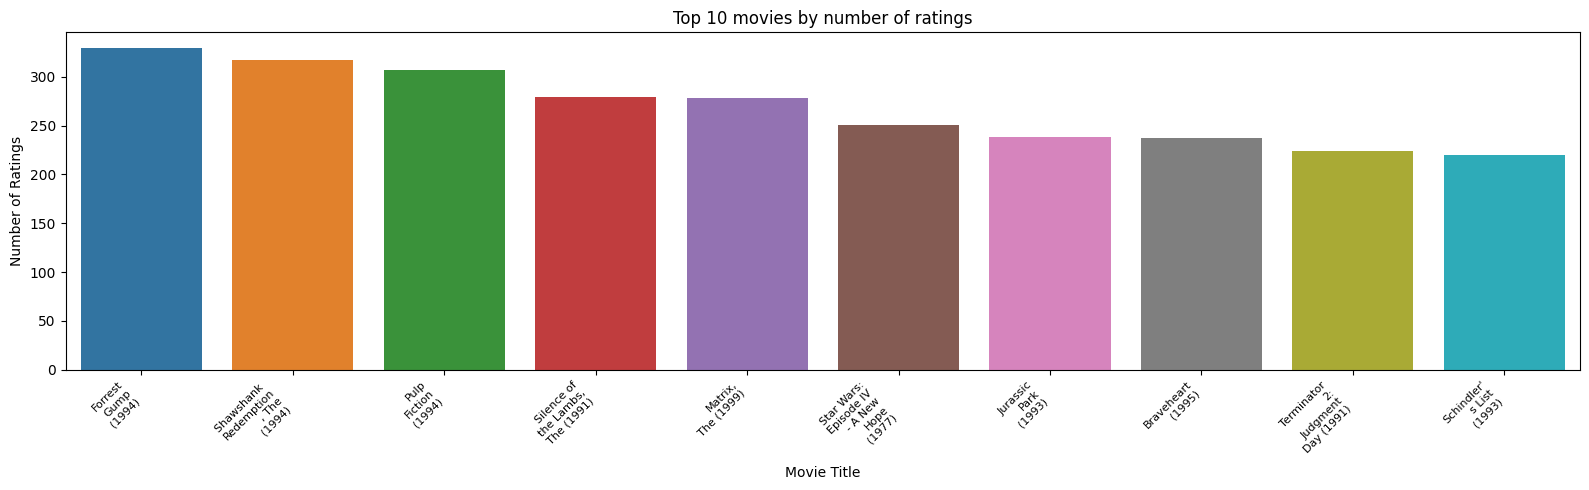

In [ ]:
# create variables for easier reuse
movies_rated_count = df_movies_raters_genres['title'].value_counts()


# Top 10 movies with the most ratings
top_movies = movies_rated_count[:10]

plt.figure(figsize=(16,5))
sns.barplot(x=top_movies.index, y=top_movies.values)
plt.xlabel("Movie Title")
plt.ylabel("Number of Ratings")
plt.title("Top 10 movies by number of ratings")

xticks_labels = top_movies.index # or replace this with your list of movie titles
plt.xticks(np.arange(len(xticks_labels)), xticks_labels, rotation=45, ha='right', fontsize=8)
plt.tight_layout()

# using textwrap to split long movie titles into multiple lines.
import textwrap
xticks_labels = [textwrap.fill(label, width=10) for label in xticks_labels]
plt.xticks(np.arange(len(xticks_labels)), xticks_labels, rotation=45, ha='right', fontsize=8)
plt.tight_layout()

plt.show();



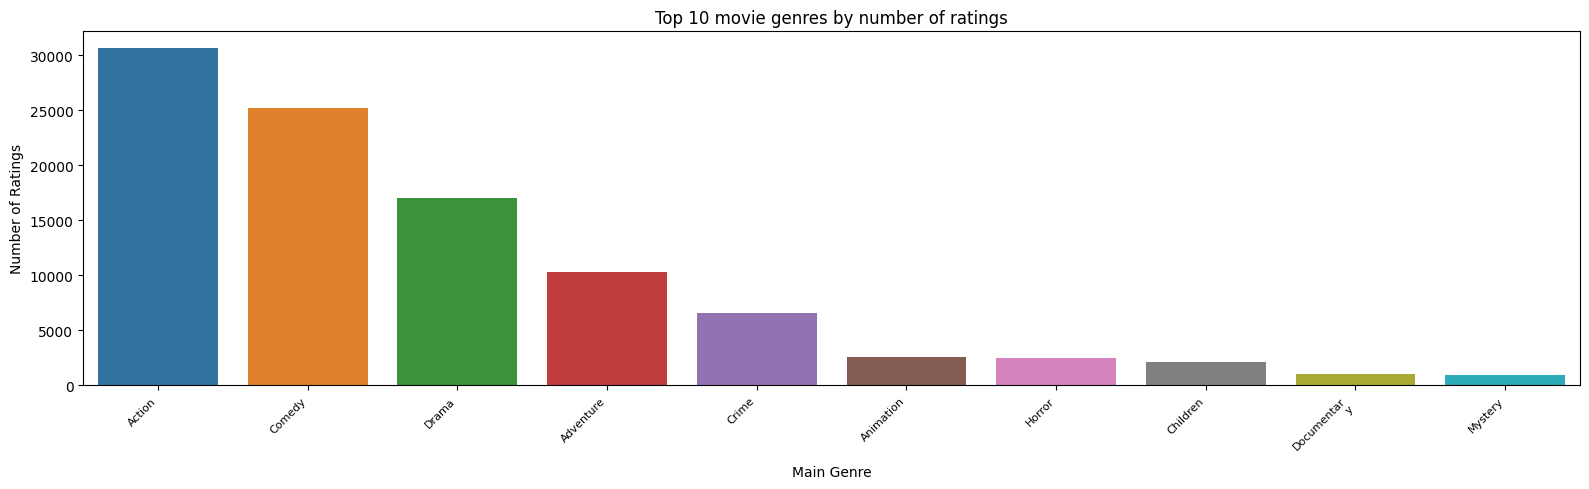

In [ ]:
# create variables for easier reuse
genres_rated_count = df_movies_raters_genres['main_genre'].value_counts()


# Top 10 genres with the most ratings
top_genres = genres_rated_count[:10]

plt.figure(figsize=(16,5))
sns.barplot(x=top_genres.index, y=top_genres.values)
plt.xlabel("Main Genre")
plt.ylabel("Number of Ratings")
plt.title("Top 10 movie genres by number of ratings")

xticks_labels = top_genres.index # or replace this with your list of movie titles
plt.xticks(np.arange(len(xticks_labels)), xticks_labels, rotation=45, ha='right', fontsize=8)
plt.tight_layout()

# using textwrap to split long movie titles into multiple lines.
import textwrap
xticks_labels = [textwrap.fill(label, width=10) for label in xticks_labels]
plt.xticks(np.arange(len(xticks_labels)), xticks_labels, rotation=45, ha='right', fontsize=8)
plt.tight_layout()

plt.show();



##Identfifying and investigating our superusers

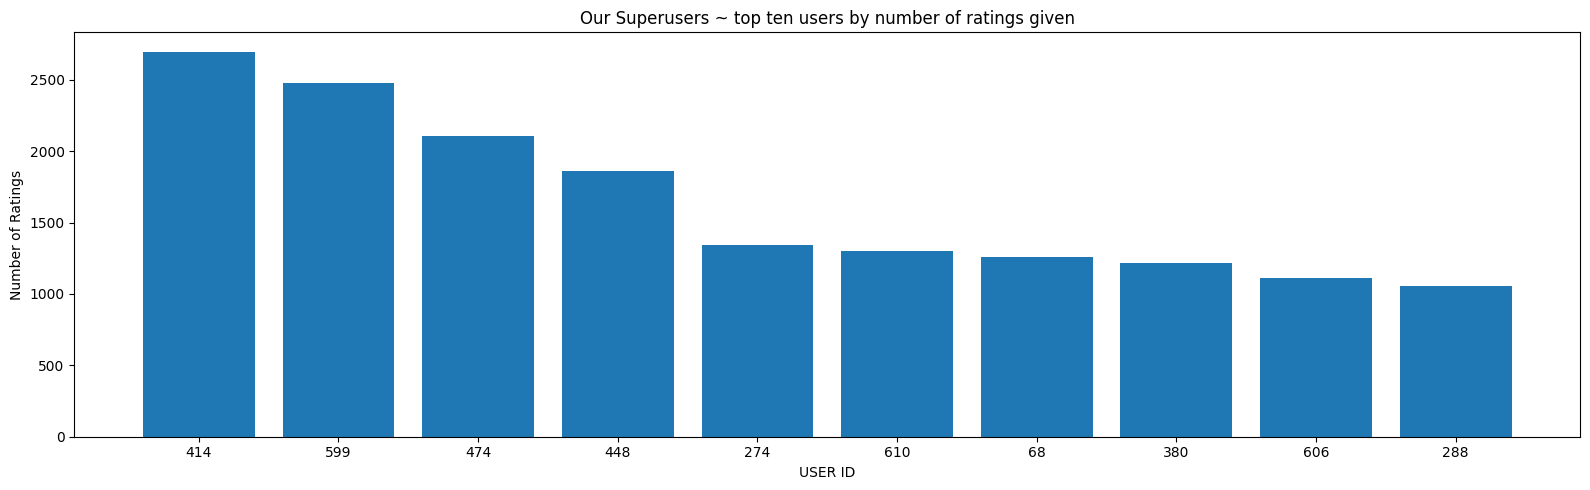

In [ ]:
# create variables for easier reuse
user_ratings_count = df_movies_raters_genres['userId'].value_counts()

# Top 10 users with the most ratings
top_users = user_ratings_count[:10]

plt.figure(figsize=(16,5))
plt.bar(x=range(len(top_users)), height=top_users.values, tick_label=top_users.index)  # Changed to plt.bar()
plt.xlabel("USER ID")
plt.ylabel("Number of Ratings")
plt.title("Our Superusers ~ top ten users by number of ratings given")

plt.tight_layout()
plt.show();

In [27]:
query = \
"""
SELECT MAX(r.rating) as highest_rating, r.movieID, m.title, m.genres, r.userID, COUNT(r.userID) AS num_movies_rated
FROM ratings as r
LEFT JOIN movies AS m ON m.movieId = r.movieId
GROUP BY r.userId
ORDER BY num_movies_rated DESC;
"""
df_movie_raters = pd.read_sql_query(sql=text(query), con=engine.connect())

In [28]:
df_movie_raters.head(10)

,highest_rating,movieId,title,genres,userId,num_movies_rated
0,5.0,11,"American President, The (1995)",Comedy|Drama|Romance,414,2698
1,5.0,112,Rumble in the Bronx (Hont faan kui) (1995),Action|Adventure|Comedy|Crime,599,2478
2,5.0,17,Sense and Sensibility (1995),Drama|Romance,474,2108
3,5.0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,448,1864
4,5.0,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,274,1346
5,5.0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,610,1302
6,5.0,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,68,1260
7,5.0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,380,1218
8,5.0,232,Eat Drink Man Woman (Yin shi nan nu) (1994),Comedy|Drama|Romance,606,1115
9,5.0,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller,288,1055


In [29]:
df_movie_raters.tail()

,highest_rating,movieId,title,genres,userId,num_movies_rated
605,5.0,2858,American Beauty (1999),Drama|Romance,207,20
606,4.5,1090,Platoon (1986),Drama|War,194,20
607,5.0,58559,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX,189,20
608,5.0,225,Disclosure (1994),Drama|Thriller,147,20
609,5.0,203,"To Wong Foo, Thanks for Everything! Julie Newm...",Comedy,53,20


In [30]:
df_movie_raters.describe()

,highest_rating,movieId,userId,num_movies_rated
count,610.000000,610.000000,610.000000,610.000000
mean,4.957377,2452.804918,305.500000,165.304918
std,0.191750,13999.538480,176.236111,269.480584
min,2.500000,1.000000,1.000000,20.000000
25%,5.000000,32.000000,153.250000,35.000000
50%,5.000000,150.000000,305.500000,70.500000
75%,5.000000,527.000000,457.750000,168.000000
max,5.000000,177765.000000,610.000000,2698.000000


In [ ]:
query = \
"""
SELECT r.userID, m.title, m.genres, r.rating, MAX(r.rating) as highest_rated, COUNT(r.userID) AS num_movies_rated
FROM ratings AS r
JOIN movies AS m ON m.movieId = r.movieId
GROUP BY r.userID
ORDER BY num_movies_rated DESC;
"""
df_users_highest_rated_movies = pd.read_sql_query(sql=text(query), con=engine.connect())

In [ ]:
df_users_highest_rated_movies.head(10)

,userId,title,genres,rating,highest_rated,num_movies_rated
0,414,"American President, The (1995)",Comedy|Drama|Romance,5.0,5.0,2698
1,599,Rumble in the Bronx (Hont faan kui) (1995),Action|Adventure|Comedy|Crime,5.0,5.0,2478
2,474,Sense and Sensibility (1995),Drama|Romance,5.0,5.0,2108
3,448,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0,5.0,1864
4,274,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,5.0,5.0,1346
5,610,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0,5.0,1302
6,68,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,5.0,5.0,1260
7,380,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0,5.0,1218
8,606,Eat Drink Man Woman (Yin shi nan nu) (1994),Comedy|Drama|Romance,5.0,5.0,1115
9,288,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller,5.0,5.0,1055


In [ ]:
df_users_highest_rated_movies.tail(10)

,userId,title,genres,rating,highest_rated,num_movies_rated
600,431,True Romance (1993),Crime|Thriller,5.0,5.0,20
601,406,Ever After: A Cinderella Story (1998),Comedy|Drama|Romance,5.0,5.0,20
602,320,"Negotiator, The (1998)",Action|Crime|Drama|Mystery|Thriller,4.0,4.0,20
603,278,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,5.0,5.0,20
604,257,This Is Spinal Tap (1984),Comedy,4.5,4.5,20
605,207,American Beauty (1999),Drama|Romance,5.0,5.0,20
606,194,Platoon (1986),Drama|War,4.5,4.5,20
607,189,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX,5.0,5.0,20
608,147,Disclosure (1994),Drama|Thriller,5.0,5.0,20
609,53,"To Wong Foo, Thanks for Everything! Julie Newm...",Comedy,5.0,5.0,20


In [ ]:
query = \
"""
SELECT r.userID, COUNT(r.userID) AS num_movies_rated
FROM ratings as r
LEFT JOIN movies AS m ON m.movieId = r.movieId
GROUP BY r.userId
ORDER BY num_movies_rated DESC;
"""
df_raters_ratings_count = pd.read_sql_query(sql=text(query), con=engine.connect())

In [ ]:
df_raters_ratings_count.head(10)

,userId,num_movies_rated
0,414,2698
1,599,2478
2,474,2108
3,448,1864
4,274,1346
5,610,1302
6,68,1260
7,380,1218
8,606,1115
9,288,1055


In [ ]:
# plot of the number of ratings by user — see Tableau

In [44]:
# Biggest Superuser: 414

query = \
"""
SELECT r.userID, m.title, m.genres, r.rating
FROM ratings AS r
JOIN movies AS m ON m.movieId = r.movieId
WHERE r.userId = 414
ORDER BY r.rating DESC;
"""
df_super_user_414 = pd.read_sql_query(sql=text(query), con=engine.connect())

In [45]:
df_super_user_414.head(10)

,userId,title,genres,rating
0,414,"American President, The (1995)",Comedy|Drama|Romance,5.0
1,414,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller,5.0
2,414,Babe (1995),Children|Drama,5.0
3,414,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,5.0
4,414,Beautiful Girls (1996),Comedy|Drama|Romance,5.0
5,414,Braveheart (1995),Action|Drama|War,5.0
6,414,Taxi Driver (1976),Crime|Drama|Thriller,5.0
7,414,Rob Roy (1995),Action|Drama|Romance|War,5.0
8,414,Clerks (1994),Comedy,5.0
9,414,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,5.0


In [46]:
df_super_user_414.tail(10)

,userId,title,genres,rating
2688,414,America's Sweethearts (2001),Comedy|Romance,1.0
2689,414,She's Out of Control (1989),Comedy,1.0
2690,414,Three Fugitives (1989),Action|Comedy,1.0
2691,414,Sheena (1984),Action|Adventure|Fantasy,1.0
2692,414,Fraternity Vacation (1985),Comedy|Romance,1.0
2693,414,Wild Orchid (1990),Drama|Romance,1.0
2694,414,Look Who's Talking Now (1993),Children|Comedy|Romance,1.0
2695,414,"Tuxedo, The (2002)",Action|Comedy,1.0
2696,414,Eve of Destruction (1991),Action|Sci-Fi|Thriller,1.0
2697,414,Catwoman (2004),Action|Crime|Fantasy,0.5


In [47]:
df_super_user_414['rating'].value_counts()

4.0    903
3.0    658
2.0    398
5.0    248
3.5    232
2.5    122
4.5     76
1.0     40
1.5     20
0.5      1
Name: rating, dtype: int64

In [48]:
df_super_user_414['genres'].value_counts()

Drama                                                  257
Comedy                                                 238
Comedy|Drama                                           137
Comedy|Romance                                         121
Comedy|Drama|Romance                                   105
                                                      ... 
Documentary|IMAX                                         1
Adventure|Animation|Fantasy|Sci-Fi                       1
Adventure|Animation|Children|Comedy|Fantasy|Romance      1
Action|Adventure|Animation|Children|Sci-Fi               1
Action|Crime|Fantasy                                     1
Name: genres, Length: 482, dtype: int64

In [40]:
# Second biggest superuser: 599

query = \
"""
SELECT r.userID, m.title, m.genres, r.rating
FROM ratings AS r
JOIN movies AS m ON m.movieId = r.movieId
WHERE r.userId = 599
ORDER BY r.rating DESC;
"""
df_super_user_599 = pd.read_sql_query(sql=text(query), con=engine.connect())

In [41]:
df_super_user_599.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2478 entries, 0 to 2477
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   userId  2478 non-null   int64  
 1   title   2478 non-null   object 
 2   genres  2478 non-null   object 
 3   rating  2478 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 77.6+ KB


In [42]:
# super user 599 is much more critical a rater than 414
df_super_user_599['rating'].value_counts()

2.5    690
3.0    624
2.0    349
3.5    290
1.5    226
4.0    122
1.0     67
0.5     42
4.5     36
5.0     32
Name: rating, dtype: int64

In [49]:
df_super_user_599['genres'].value_counts()

Comedy                                      226
Drama                                       186
Comedy|Drama                                 91
Comedy|Romance                               77
Comedy|Drama|Romance                         67
                                           ... 
Action|Comedy|War                             1
Animation|Children|Drama|Fantasy|Musical      1
Action|Drama|Mystery|Sci-Fi|Thriller          1
Adventure|Animation|Comedy|Sci-Fi             1
Comedy|Fantasy|Horror|Sci-Fi                  1
Name: genres, Length: 524, dtype: int64